In [3]:
import numpy as np 
import pandas as pd 

from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.layers import Dropout, SpatialDropout1D, TimeDistributed,Flatten, GlobalMaxPool1D
from tensorflow.keras.layers import Embedding
from keras.layers import multiply
import seaborn as sns
import matplotlib.pyplot as plt

import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_data = pd.read_csv("/content/drive/MyDrive/questions_cleaned.csv")
test_data = pd.read_csv("/content/drive/MyDrive/questions.csv")

In [7]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0.0


In [8]:
test_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
train_data = train_data.sample(frac=0.1).reset_index(drop=True)
test_data = test_data.sample(frac=0.01).reset_index(drop=True)

In [10]:
train_data.shape,test_data.shape

((723, 6), (4044, 6))

In [11]:
train_data = train_data.drop(['id','qid1','qid2'],axis=1)
test_data = test_data.drop(['is_duplicate'],axis=1)
train_data.head()

,question1,question2,is_duplicate
0,Can non-profit organizations pay a salary?,How do Non-Profit organizations pay the salari...,1.0
1,What are some tips on making it through the jo...,What are some tips on making it through the jo...,0.0
2,How widely accepted are credit cards at small ...,How widely accepted are credit cards at small ...,0.0
3,How do I work with machine learning researcher...,How can undergraduate help with machine learni...,0.0
4,Which laptop is the most suitable with the fol...,Which laptop is most suitable with the followi...,0.0


<Axes: xlabel='is_duplicate'>

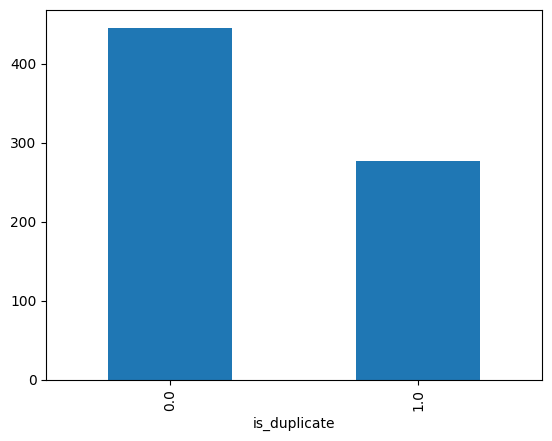

In [12]:
train_data.is_duplicate.value_counts().plot(kind='bar')

In [13]:
train_data[train_data['is_duplicate']==1].shape,train_data[train_data['is_duplicate']==0].shape

((277, 3), (446, 3))

In [14]:
is_duplicate = train_data[train_data['is_duplicate']==1]
not_duplicate = train_data[train_data['is_duplicate']==0]

In [15]:
train_data = pd.concat([is_duplicate,not_duplicate])
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data

,question1,question2,is_duplicate
0,"How IT system works in a mall, market places?",What is meant by institutional framework of pu...,0.0
1,What does Java do and do I need it?,Do I need Java on my computer?,1.0
2,Why are bad boys so attractive?,Are girls attracted to boys as much as boys ar...,0.0
3,How does the HP OfficeJet 4620 Airprint compar...,How does the HP OfficeJet 4620 Airprint compar...,1.0
4,"In Game of Thrones, is Syrio Forel one of the ...",Is Syrio Forel a faceless man following Arya a...,1.0
...,...,...,...
718,How can a girl know if a boy loving him withou...,How can a boy know if a girl likes him or not?,0.0
719,What does taking advantage of someone mean?,Is it worse to take advantage of someone or be...,0.0
720,What makes a question interesting?,What makes a question interesting to answer?,1.0
721,Which is the best hotel job vacancy website?,What are some examples of considerations in a ...,0.0


<Axes: xlabel='is_duplicate'>

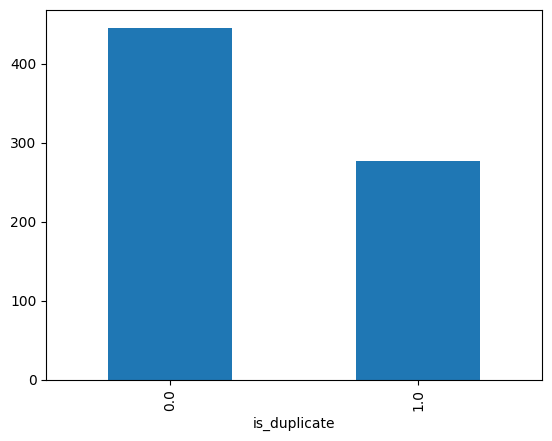

In [16]:
train_data.is_duplicate.value_counts().plot(kind='bar')

In [17]:
#Lemmatize Words

def get_pos_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()

In [18]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [19]:
#cleaning the data now

regex = [
    r'<[^>]+>', #HTML tags
    r'@(\w+)', # @-mentions
    r"#(\w+)", # hashtags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'[^0-9a-z #+_\\r\\n\\t]', #BAD SYMBOLS
]

REPLACE_URLS = re.compile(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+')
REPLACE_HASH = re.compile(r'#(\w+)')
REPLACE_AT = re.compile(r'@(\w+)')
REPLACE_HTML_TAGS = re.compile(r'<[^>]+>')
REPLACE_DIGITS = re.compile(r'\d+')
#REPLACE_BY = re.compile(r"[/(){}\[\]\|,;.:?\-\'\"$]")
REPLACE_BY = re.compile(r"[^a-z0-9\-]")

STOPWORDS = set(stopwords.words('english'))

#tokens_re = re.compile(r'('+'|'.join(regex)+')', re.VERBOSE | re.IGNORECASE)

# sentences = [] #for Word2Vec model

def clean_text(text):
  if isinstance(text, str):
    text = text.lower()
    text = REPLACE_HTML_TAGS.sub(' ', text)
    text = REPLACE_URLS.sub('', text)
    text = REPLACE_HASH.sub('', text)
    text = REPLACE_AT.sub('', text)
    text = REPLACE_DIGITS.sub(' ', text)
    text = REPLACE_BY.sub(' ', text)


    text = " ".join(lemmatizer.lemmatize(word.strip(), get_pos_tag(pos_tag([word.strip()])[0][1])) for word in text.split() if word not in STOPWORDS and len(word)>3)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
  else:
    text = ''
  return text

In [20]:
get_pos_tag(pos_tag(['playing'.strip()])[0][1])

'v'

In [21]:
pos_tag(['word'.strip()])

[('word', 'NN')]

In [22]:
lemmatizer.lemmatize('playing'.strip(), get_pos_tag(pos_tag(['playing'.strip()])[0][1]))

'play'

In [23]:
get_pos_tag(pos_tag(['playing'.strip()])[0][1])

'v'

In [24]:
lemmatizer.lemmatize('playable'.strip(),'v' )

'playable'

In [25]:
train_data['q1'] = train_data['question1'].apply(clean_text)
train_data['q2'] = train_data['question2'].apply(clean_text)

In [26]:
train_data.head()

,question1,question2,is_duplicate,q1,q2
0,"How IT system works in a mall, market places?",What is meant by institutional framework of pu...,0.0,system work mall market place,meant institutional framework public policy
1,What does Java do and do I need it?,Do I need Java on my computer?,1.0,java need,need java computer
2,Why are bad boys so attractive?,Are girls attracted to boys as much as boys ar...,0.0,boy attractive,girl attract boy much boy attract girl
3,How does the HP OfficeJet 4620 Airprint compar...,How does the HP OfficeJet 4620 Airprint compar...,1.0,officejet airprint compare laserjet enterprise,officejet airprint compare laserjet enterprise
4,"In Game of Thrones, is Syrio Forel one of the ...",Is Syrio Forel a faceless man following Arya a...,1.0,game throne syrio forel faceless,syrio forel faceless follow arya around differ...


In [27]:
test_data.question1

0       Are there any good emerging hard "rock" bands,...
1       Which fragrance is similar like reebok reeload...
2         Is gastronomy a good career for having success?
3       What are the main imports and exports of Venez...
4       What does the continuous waste tyre pyrolysis ...
                              ...                        
4039    What is the difference between a turbocharger ...
4040    Why are most of the sites to compare multiple ...
4041         Where can I learn French at home in Jodhpur?
4042    My parents took away all my entertainment devi...
4043                  How did you learn to speak English?
Name: question1, Length: 4044, dtype: object

In [28]:
test_data['q1'] = test_data['question1'].astype(str).apply(clean_text)
test_data['q2'] = test_data['question2'].astype(str).apply(clean_text)
test_data.head()

,id,qid1,qid2,question1,question2,q1,q2
0,155499,307530,307531,"Are there any good emerging hard ""rock"" bands,...",What are some good emerging hard rock bands?,good emerge hard rock band preferably young,good emerge hard rock band
1,294205,577955,577956,Which fragrance is similar like reebok reeload...,Bounce just released dryer sheets for men call...,fragrance similar like reebok reeload deodorant,bounce release dryer sheet call pure sport gue...
2,221980,437551,437552,Is gastronomy a good career for having success?,Where and how can I find a life coach or mentor?,gastronomy good career success,find life coach mentor
3,171816,339496,339497,What are the main imports and exports of Venez...,What are the main imports and exports of Venez...,main import export venezuela venezuela industr...,main import export venezuela venezuela industr...
4,153588,303779,303780,What does the continuous waste tyre pyrolysis ...,What is the continuous waste plastic Pyrolysis...,continuous waste tyre pyrolysis plant work pro...,continuous waste plastic pyrolysis plant work ...


In [29]:
#max len of clean data
max_len_q1 = np.max(train_data["q1"].apply(lambda x: len(x.split())))
max_len_q2 = np.max(train_data["q2"].apply(lambda x: len(x.split())))
max_len_q1, max_len_q2

(19, 24)

In [30]:
MAX_NB_WORDS = 200000

tokenizer = Tokenizer(num_words = MAX_NB_WORDS)

tokenizer.fit_on_texts(list(train_data['q1'].values.astype(str))+list(train_data['q2'].values.astype(str)))


X_train_q1 = tokenizer.texts_to_sequences(train_data['q1'].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen = 30, padding = 'post')

X_train_q2 = tokenizer.texts_to_sequences(train_data['q2'].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen = 30, padding = 'post')

In [31]:
X_test_q1 = tokenizer.texts_to_sequences(test_data['q1'].ravel())
X_test_q1 = pad_sequences(X_test_q1,maxlen = 30, padding='post')

X_test_q2 = tokenizer.texts_to_sequences(test_data['q2'].astype(str).ravel())
X_test_q2 = pad_sequences(X_test_q2, maxlen = 30, padding='post')

In [32]:
y = train_data['is_duplicate']

In [33]:
vocab_size = len(tokenizer.word_index) + 1

In [35]:
X_train_q1,X_valid_q1, X_train_q2, X_valid_q2, y_train, y_valid = train_test_split(X_train_q1, X_train_q2, y, test_size=0.20, random_state=12)
print(X_train_q1.shape, X_train_q2.shape, y_train.shape)
print(X_valid_q1.shape, X_valid_q2.shape, y_valid.shape)

(578, 30) (578, 30) (578,)
(145, 30) (145, 30) (145,)


In [36]:
# Model for Q1

model_q1 = Sequential([Embedding(input_dim = vocab_size,output_dim = 200,weights = [embedding_matrix],input_length = 30),
                      LSTM(128, activation = 'tanh', return_sequences = True),
                      Dropout(0.2),
                      LSTM(128, return_sequences = True),
                      LSTM(128),
                      Dense(60, activation = 'tanh'),
                      Dense(2, activation = 'sigmoid')])

In [37]:
# Model for Q2

model_q2 = Sequential([Embedding(input_dim = vocab_size,output_dim = 200,weights = [embedding_matrix],input_length = 30),
                      LSTM(128, activation = 'tanh', return_sequences = True),
                      Dropout(0.2),
                      LSTM(128, return_sequences = True),
                      LSTM(128),
                      Dense(60, activation = 'tanh'),
                      Dense(2, activation = 'sigmoid')])

In [38]:
# Merging the output of the two models,i.e, model_q1 and model_q2
mergedOut = multiply([model_q1.output, model_q2.output])

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(100, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(50, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(2, activation = 'sigmoid')(mergedOut)

In [39]:
new_model = tf.keras.Model([model_q1.input, model_q2.input], mergedOut)
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

In [40]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 30)]                 0         []                            
 r)                                                                                               
                                                                                                  
 embedding_1_input (InputLa  [(None, 30)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding (Embedding)       (None, 30, 200)              461600    ['embedding_input[0][0]']     
                                                                                              

In [43]:
history = new_model.fit([X_train_q1,X_train_q2],y_train, batch_size = 2000, epochs = 20, validation_data = ([X_valid_q1,X_valid_q2],y_valid))

Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 0.6952 - accuracy: 0.4550 - val_loss: 0.6926 - val_accuracy: 0.6483
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 0.6914 - accuracy: 0.5363 - val_loss: 0.6889 - val_accuracy: 0.6483
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 0.6899 - accuracy: 0.5623 - val_loss: 0.6853 - val_accuracy: 0.6483
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.6869 - accuracy: 0.5952 - val_loss: 0.6817 - val_accuracy: 0.6483
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.6853 - accuracy: 0.6038 - val_loss: 0.6783 - val_accuracy: 0.6483
Epoch 6/20
1/1 [==============================] - 4s 4s/step - loss: 0.6811 - accuracy: 0.6073 - val_loss: 0.6747 - val_accuracy: 0.6483
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 0.6809 - accuracy: 0.6038 - val_loss: 0.6711 - val_accuracy: 0.6483
Epoch 8/20
1/1 [=======================

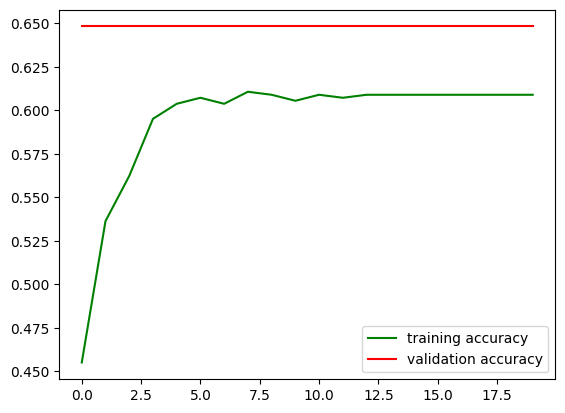

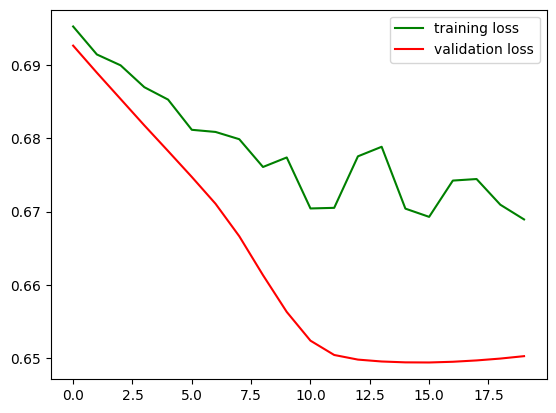

In [44]:
accuracy = history.history["accuracy"]
loss = history.history["loss"]

val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

#plot
plt.plot(accuracy,'g',label='training accuracy')
plt.plot(val_accuracy, 'r', label='validation accuracy')
plt.legend()
plt.show()


plt.plot(loss,'g',label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

In [45]:
y_pred = new_model.predict([X_test_q1, X_test_q2])

127/127 [==============================] - 15s 97ms/step


In [46]:
np.argmax(y_pred[:10], axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [47]:
train_data.head()

,question1,question2,is_duplicate,q1,q2
0,"How IT system works in a mall, market places?",What is meant by institutional framework of pu...,0.0,system work mall market place,meant institutional framework public policy
1,What does Java do and do I need it?,Do I need Java on my computer?,1.0,java need,need java computer
2,Why are bad boys so attractive?,Are girls attracted to boys as much as boys ar...,0.0,boy attractive,girl attract boy much boy attract girl
3,How does the HP OfficeJet 4620 Airprint compar...,How does the HP OfficeJet 4620 Airprint compar...,1.0,officejet airprint compare laserjet enterprise,officejet airprint compare laserjet enterprise
4,"In Game of Thrones, is Syrio Forel one of the ...",Is Syrio Forel a faceless man following Arya a...,1.0,game throne syrio forel faceless,syrio forel faceless follow arya around differ...


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [49]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


In [67]:
vectorizer = TfidfVectorizer()
a = vectorizer.fit_transform(train_data['q1'])
b = vectorizer.fit_transform(train_data['q2'])
A=vectorizer.fit_transform(test_data['q1'])
B=vectorizer.fit_transform(test_data['q2'])
A = A[:, :1730]
B = B[:, :1730]

In [68]:
combined_tfidf = np.hstack([a.toarray(), b.toarray()])

# Print the shape of the combined TF-IDF vectors
print(combined_tfidf.shape)

# Convert the combined TF-IDF vectors to a DataFrame if needed
combined_tfidf_df = pd.DataFrame(combined_tfidf)


(723, 3460)


In [69]:
y = train_data['is_duplicate']
y.shape

(723,)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(combined_tfidf_df, y, test_size=0.2, random_state=0)

# Initialize and train the SVM model
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm.predict(X_test)

# Print evaluation metrics
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.6
              precision    recall  f1-score   support

         0.0       0.63      0.78      0.70        86
         1.0       0.51      0.34      0.41        59

    accuracy                           0.60       145
   macro avg       0.57      0.56      0.55       145
weighted avg       0.58      0.60      0.58       145



In [71]:
combined_v = np.hstack([A.toarray(), B.toarray()])
test = pd.DataFrame(combined_v)

In [72]:
prediction = svm.predict(test[:10])
prediction

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [56]:
!pip install mtranslate


  Preparing metadata (setup.py) ... done
  Created wheel for mtranslate: filename=mtranslate-1.8-py3-none-any.whl size=3672 sha256=a063ff515aad7c563f788b48a35049e9ab1c9b8a1f087c0a56a53dbac1ecab89
  Stored in directory: /root/.cache/pip/wheels/c2/04/15/d7654c2c4a9a52e09922967593f3278fed66059be65ca671ea
Successfully built mtranslate


In [76]:
from mtranslate import translate


text = "What does Java do and do I need it?	"
language = 'te'
result=translate(text,language)
print(result)

జావా ఏమి చేస్తుంది మరియు నాకు ఇది అవసరమా?


In [85]:
from mtranslate import translate
def predict_duplicates(question1, question2):
    text1=question1
    text2=question2
    language="en"
    result1=translate(text1,language)
    result2=translate(text2,language)
    print(result1)
    print(result2)
    res1=clean_text(result1)
    res2=clean_text(result2)
    # Vectorize the user-input questions
    A= vectorizer.transform([res1])
    B= vectorizer.transform([res2])

    A = A[:, :1730]
    B = B[:, :1730]


    # Combine the vectors to predict as a pair
    combined_tfidf = np.hstack([A.toarray(), B.toarray()])

    # Predict using the SVM model
    prediction = svm.predict(combined_tfidf)

    # Print the prediction
    if prediction[0] == 0:
        print("These questions are duplicates.")
    else:
        print("These questions are not duplicates.")

# Example usage: Taking input from the user
question1 = input("Enter the first question: ")
question2 = input("Enter the second question: ")

# Predict duplicates
predict_duplicates(question1, question2)

Enter the first question: Do I need Java on my computer?
Enter the second question: జావా ఏమి చేస్తుంది మరియు నాకు ఇది అవసరమా?
Do I need Java on my computer?
What does Java do and do I need it?
These questions are duplicates.
